## Technical Screening -- Vantiv

Mobing Zhuang

04/06/2018

In [339]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline
# to change default colormap
plt.rcParams["image.cmap"] = "Set1"
# to change default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from statsmodels.graphics.mosaicplot import mosaic
from matplotlib import pyplot
import seaborn

import requests
import json
import pandas as pd
from pandas.io.json import json_normalize
import copy
# from datetime import datetime
import datetime
import plotly
import plotly.graph_objs as go
from plotly import tools

plotly.__version__
plotly.offline.init_notebook_mode(connected=True)
plotly.plotly.sign_in('45220Zmb', '9EywutMKCyDsD5WpWSp9')

import scipy
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
# jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
# import mylib

### Step 1. Data cleaning

#### Data structure and data types
Get the basic information of the data and fix data types if necessary.

In [352]:
df = pd.read_csv("data/data.txt", sep="\t")
# Summary of the data
print("Dimension of the data", df.shape)
print("Variables are:", df.columns.values)

Dimension of the data (813940, 9)
Variables are: ['Account_ID' 'Transaction_Timestamp' 'Factor_A' 'Factor_B' 'Factor_C'
 'Factor_D' 'Factor_E' 'Response' 'Transaction_Status']


In [353]:
# Data types
df.dtypes

Account_ID                int64
Transaction_Timestamp    object
Factor_A                  int64
Factor_B                  int64
Factor_C                 object
Factor_D                  int64
Factor_E                 object
Response                  int64
Transaction_Status       object
dtype: object

In [354]:
# Convert "Factor_C", "Factor_E", "Response", and "Transaction_Status" to categorical
df['Response'] = df['Response'].astype('category')
cleanup = {"Transaction_Status": {"Approved": 1, "Declined": 0}}
df.replace(cleanup, inplace=True)
# df['Transaction_Status'] = df['Transaction_Status'].astype('category')
# df['Factor_C'] = df['Factor_C'].astype('category')
# df['Factor_E'] = df['Factor_E'].astype('category')
# Construct a new variable "Transaction_Timestamp_New" based on "Transaction_Status"
# The new variables's data type is datetime64
df['Transaction_Timestamp_New'] = [datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S.%f") for i in df['Transaction_Timestamp']]

Lets's check the data frame after data types conversion.

In [355]:
df.describe(include='all')

,Account_ID,Transaction_Timestamp,Factor_A,Factor_B,Factor_C,Factor_D,Factor_E,Response,Transaction_Status,Transaction_Timestamp_New
count,813940.000000,813940,813940.000000,813940.000000,813940,813940.000000,585543,813940.0,813940.000000,813940
unique,NaN,813889,NaN,NaN,4,NaN,62,44.0,NaN,813889
top,NaN,2009-12-06 16:11:15.836,NaN,NaN,VI,NaN,H,1020.0,NaN,2009-12-30 17:53:51.561000
freq,NaN,2,NaN,NaN,438189,NaN,127531,710054.0,NaN,2
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-01-01 00:02:57.867000
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-12-31 23:57:20.559000
mean,267182.942948,NaN,5.290133,10.273524,NaN,22.039644,NaN,NaN,0.885254,NaN
std,158613.468018,NaN,3.865309,5.797433,NaN,6.807511,NaN,NaN,0.318715,NaN
min,1.000000,NaN,0.000000,0.000000,NaN,10.000000,NaN,NaN,0.000000,NaN
25%,129351.750000,NaN,2.000000,6.000000,NaN,20.000000,NaN,NaN,1.000000,NaN


#### Missing value
First, check the percentile of missing values for each column.

In [179]:
# Missing values
round(df.isnull().sum()/df.shape[0], 2)*100

Account_ID                    0.0
Transaction_Timestamp         0.0
Factor_A                      0.0
Factor_B                      0.0
Factor_C                      0.0
Factor_D                      0.0
Factor_E                     28.0
Response                      0.0
Transaction_Status            0.0
Transaction_Timestamp_New     0.0
dtype: float64

There are 28% missing values in Factor_E. Since it's a categorical variable, let's impute it as "Missing" and treat it just as another level for this categorical variable.

In [180]:
df.Factor_E = df.Factor_E.fillna("Missing")

### Step 2. Exploratory Analysis

#### How does each variable correlate with the transaction status?

#### a. Response vs. Transaction Status

In [217]:
ct = pd.crosstab(df.Transaction_Status, df.Response)
stacked = ct.stack().reset_index().rename(columns={0:'value'})
stacked[stacked.value != 0]

,Transaction_Status,Response,value
0,Approved,1020,710054
39,Approved,1885,10490
45,Declined,1026,77
46,Declined,1028,1
47,Declined,1060,3474
48,Declined,1070,148
49,Declined,1080,58
50,Declined,1100,1900
51,Declined,1130,5
52,Declined,1220,15


As shown above, the approval response codes 1020 and 1885. All the other codes indicate declining.  

#### b. Response vs. Numeric Variables (Factor A, B, D)

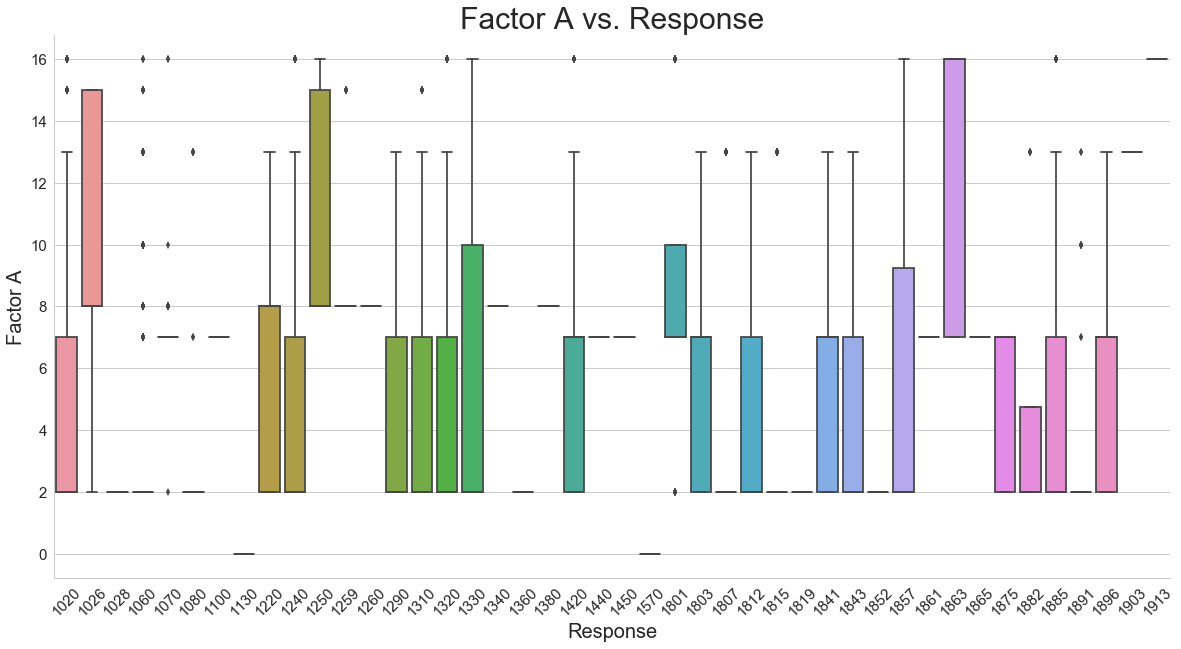

In [265]:
# sns.set_style("whitegrid")
fig, ax = pyplot.subplots(figsize=(20,10))
g = sns.boxplot(df.Factor_A, groupby = df.Response)
g.axes.set_title("Factor A vs. Response",fontsize=30)
g.set_xlabel("Response",fontsize=20)
g.set_ylabel("Factor A",fontsize=20)
g.tick_params(labelsize=15)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
sns.despine()

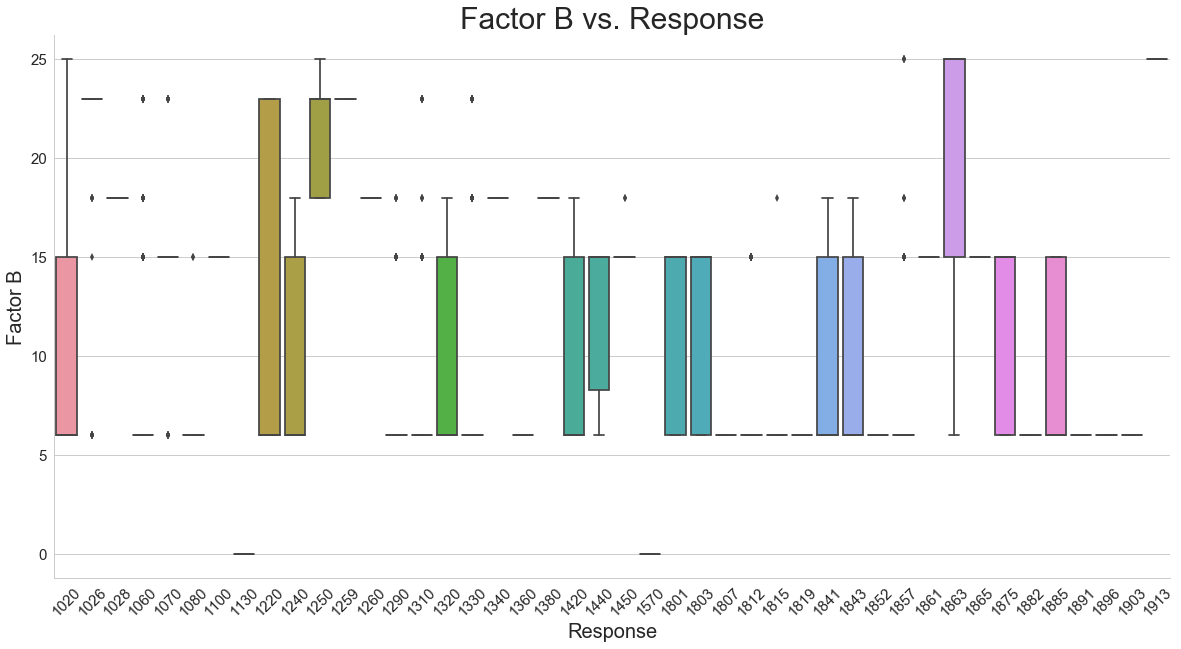

In [266]:
fig, ax = pyplot.subplots(figsize=(20,10))
g = sns.boxplot(df.Factor_B, groupby = df.Response)
g.axes.set_title("Factor B vs. Response",fontsize=30)
g.set_xlabel("Response",fontsize=20)
g.set_ylabel("Factor B",fontsize=20)
g.tick_params(labelsize=15)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
sns.despine()

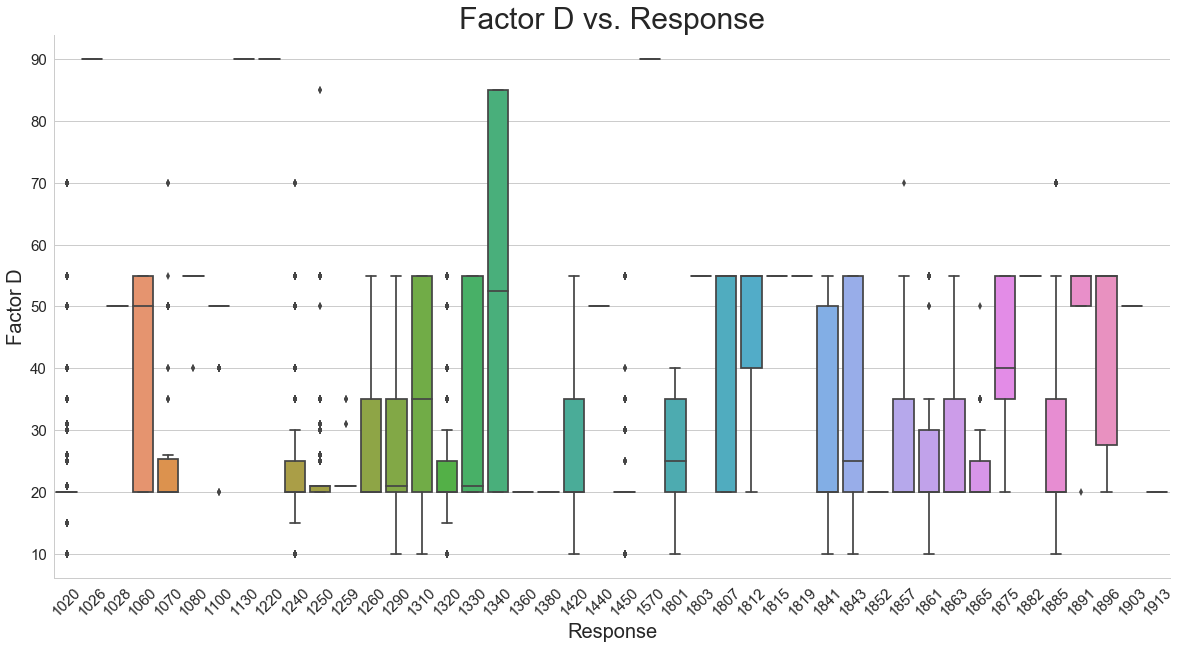

In [267]:
fig, ax = pyplot.subplots(figsize=(20,10))
g = sns.boxplot(df.Factor_D, groupby = df.Response)
g.axes.set_title("Factor D vs. Response",fontsize=30)
g.set_xlabel("Response",fontsize=20)
g.set_ylabel("Factor D",fontsize=20)
g.tick_params(labelsize=15)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
sns.despine()

Although it's not a strong tendency
According to the above figures, there isn't a clear relationship between response code and numerical variables. To explore the numerical variables deeper, let's look at the coorelation between the numerical variables.

#### c. Correlations between Numeric variables

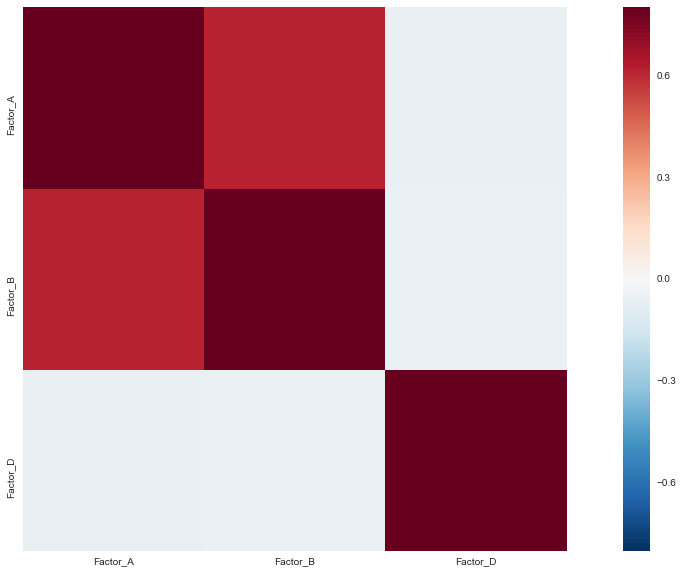

In [274]:
df_num = df.loc[:,["Factor_A", "Factor_B", "Factor_D"]]
corrmat = df_num.corr()
fig, ax = pyplot.subplots(figsize=(20,10))
sns.heatmap(corrmat, vmax=.8, square=True);

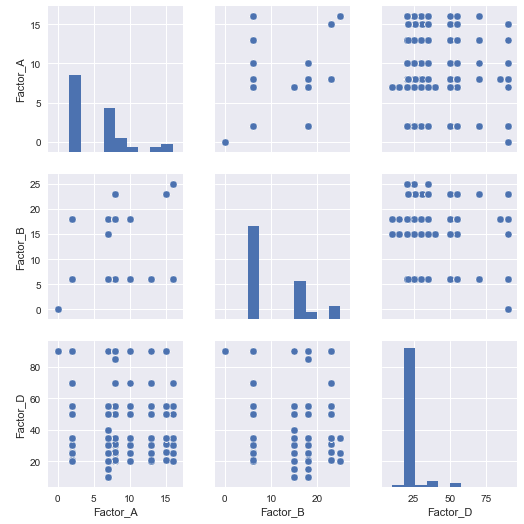

In [275]:
#scatterplot
sns.set()
cols = ['Factor_A', 'Factor_B', 'Factor_D']
sns.pairplot(df[cols], size = 2.5)
plt.show()

As shown both in the correlation heatmap and scatterplot, factor A and B are moderately linearly correlated, with a correlation coeeficient of 0.5.

#### d. Response vs. Categorical Variables (Factor C and E, as well as treating factor A, B, D as vategorical)¶

Since we don't identify a strong relationship between response and numeric factors A, B, and D. In this step we will also try treating them as categorical variables and test if there is any dependency between those factors and the response code.

In [301]:
ct = pd.crosstab(df.Factor_C, df.Response)
# df['Factor_C'] = df['Factor_C'].astype('category')
# df['Factor_E'] = df['Factor_E'].astype('category')
g, p, dof, expctd = chi2_contingency(ct)
print("Variable dependency test for factor C vs. Response, p =", p)
ct = pd.crosstab(df.Factor_E, df.Response)
g, p, dof, expctd = chi2_contingency(ct)
print("Variable dependency test for factor E vs. Response, p =", p)
ct = pd.crosstab(df.Factor_A, df.Response)
g, p, dof, expctd = chi2_contingency(ct)
print("Variable dependency test for factor A vs. Response, p =", p)
ct = pd.crosstab(df.Factor_B, df.Response)
g, p, dof, expctd = chi2_contingency(ct)
print("Variable dependency test for factor B vs. Response, p =", p)
ct = pd.crosstab(df.Factor_D, df.Response)
g, p, dof, expctd = chi2_contingency(ct)
print("Variable dependency test for factor D vs. Response, p =", p)

Variable dependency test for factor C vs. Response, p = 0.0
Variable dependency test for factor E vs. Response, p = 0.0
Variable dependency test for factor A vs. Response, p = 0.0
Variable dependency test for factor B vs. Response, p = 0.0
Variable dependency test for factor D vs. Response, p = 0.0


As shown above, all factors seem to have predicting power on the response.

#### e. Trend Over TIme
What is the trend of approval rate over time?

In [356]:
# Data munging on the transaction timestamp
df['year'] = df['Transaction_Timestamp_New'].dt.year
df['month'] = df['Transaction_Timestamp_New'].dt.month
print(max(df['year']))
print(min(df['year']))

2009
2009


All the data are from the year 2009, we can aggregate the approval rate on monthly level.

In [368]:
pd.DataFrame(rate_by_month).columns

Index(['Transaction_Status'], dtype='object')

In [385]:
rate_by_month = pd.DataFrame(df.groupby(["month"]).Transaction_Status.mean())
rate_by_month["month"] = rate_by_month.index
count_by_month =pd.DataFrame(df.groupby(["month"]).Transaction_Status.count())

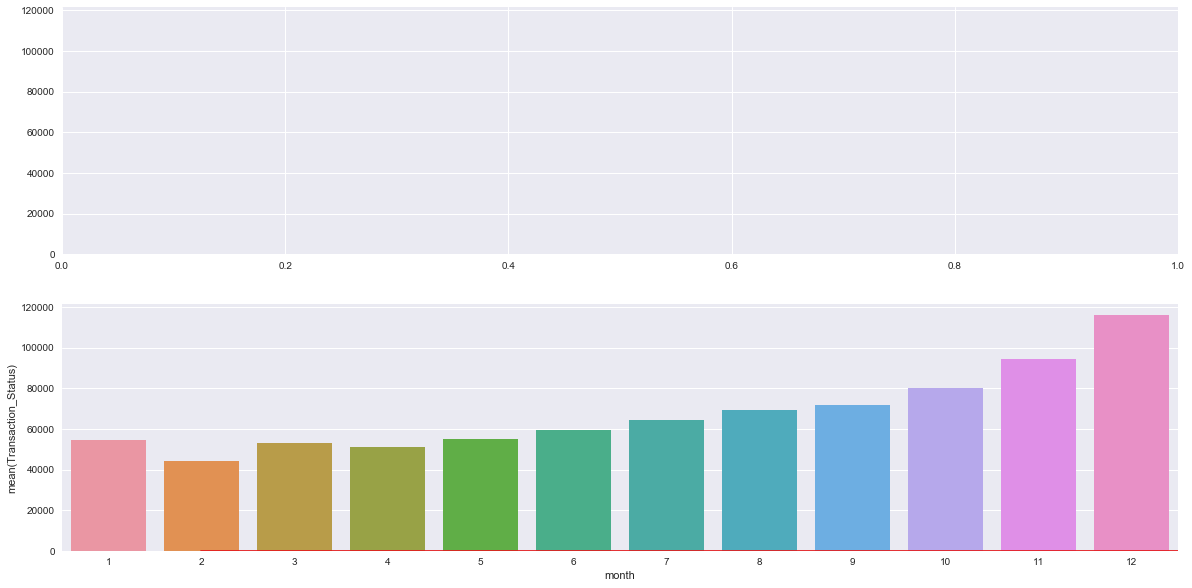

In [390]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(20,10))
plt.plot(rate_by_month.month, rate_by_month.Transaction_Status)
# ax1.set_title('Sharing X axis')
sns.barplot(count_by_month.index, count_by_month.Transaction_Status)

plt.show()

month
1      54535
2      44380
3      53259
4      51033
5      55079
6      59666
7      64268
8      69492
9      71855
10     80277
11     94315
12    115781
Name: Transaction_Status, dtype: int64

In [311]:
df

,Account_ID,Transaction_Timestamp,Factor_A,Factor_B,Factor_C,Factor_D,Factor_E,Response,Transaction_Status,Transaction_Timestamp_New
0,1,2009-07-13 19:08:50.384,8,23,AX,21,Missing,1020,Approved,2009-07-13 19:08:50.384
1,2,2009-11-18 22:58:29.197,7,15,MC,20,MCG,1020,Approved,2009-11-18 22:58:29.197
2,2,2009-11-25 11:24:29.925,7,15,MC,50,MCG,1100,Declined,2009-11-25 11:24:29.925
3,2,2009-11-25 11:26:15.255,7,15,MC,50,MCG,1100,Declined,2009-11-25 11:26:15.255
4,2,2009-11-25 12:12:34.338,7,15,MC,20,MCG,1020,Approved,2009-11-25 12:12:34.338
5,3,2009-02-21 23:23:47.602,2,6,VI,20,B,1020,Approved,2009-02-21 23:23:47.602
6,3,2009-03-09 00:12:28.977,2,6,VI,20,B,1020,Approved,2009-03-09 00:12:28.977
7,4,2009-08-17 14:20:06.377,8,23,AX,21,Missing,1020,Approved,2009-08-17 14:20:06.377
8,5,2009-01-08 00:16:41.655,2,6,VI,20,A,1020,Approved,2009-01-08 00:16:41.655
9,6,2009-08-31 17:33:42.897,2,6,VI,25,G2,1020,Approved,2009-08-31 17:33:42.897


### Step 3. Use Gradient Boosting Machine(GBM) to Predict Response Code

In [308]:
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

In [ ]:
lr1 = LogisticRegressionCV(class_weight='balanced', multi_class='multinomial', penalty='l2')
lr1.fit(x_train, y_train)
check1 = lr1.predict(x_valid)
accuracy_score(y_valid, check1)

In [ ]:
lr1 = LogisticRegressionCV(class_weight='balanced', multi_class='multinomial', penalty='l2')
lr1.fit(x_train, y_train)

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
GridSearchCV(cv=None, estimator=LogisticRegression(C=1.0, penalty='l2', tol=0.0001), \
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

In [305]:
X = df[['Factor_A', 'Factor_B', 'Factor_C', 'Factor_D', 'Factor_E']]
y = df[['Response']]

In [307]:
searchCV = LogisticRegressionCV(
        Cs=list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='roc_auc'
        ,cv=10
        ,random_state=777
        ,max_iter=10000
        ,fit_intercept=True
        ,solver='newton-cg'
        ,tol=10
    )
searchCV.fit(X, y)
print ('Max auc_roc:', searchCV.scores_[1].max())

ValueError: could not convert string to float: 'D'

In [300]:
type(ct)

pandas.core.frame.DataFrame

In [279]:
house = [ [ 215, 143 ], [ 19, 64 ] ]
chi2, p, ddof, expected = scipy.stats.chi2_contingency( house )
msg = "Test Statistic: {}\np-value: {}\nDegrees of Freedom: {}\n"
print( msg.format( chi2, p, ddof ) )
print( expected )

Test Statistic: 35.88776864806809
p-value: 2.090167442184169e-09
Degrees of Freedom: 1

[[ 189.95918367  168.04081633]
 [  44.04081633   38.95918367]]


In [282]:
ct = pd.crosstab(df.Factor_C, df.Response)
ct
# stacked = ct.stack().reset_index().rename(columns={0:'value'})
# stacked
# stacked[stacked.value != 0]

Response,1020,1026,1028,1060,1070,1080,1100,1130,1220,1240,...,1861,1863,1865,1875,1882,1885,1891,1896,1903,1913
Factor_C,,,,,,,,,,,,,,,,,,,,,
AX,98576,68,0,20,8,0,0,5,7,0,...,0,0,0,0,0,0,0,0,0,0
DI,31625,0,0,14,3,0,0,0,2,789,...,0,12,0,0,0,418,5,0,0,13
MC,198607,1,0,681,136,2,1900,0,0,6024,...,667,7,206,8,0,3008,2,16,0,0
VI,381246,8,1,2759,1,56,0,0,6,8963,...,0,0,0,5,16,7064,32,10,2,0


In [ ]:
box_plot_data=[value1,value2,value3,value4]
box=plt.boxplot(box_plot_data,vert=0,patch_artist=True,labels=['course1','course2','course3','course4'],
            )
 
colors = ['cyan', 'lightblue', 'lightgreen', 'tan']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()

In [250]:
Response_code = list(set(df.Response))
data = []
for i in range(len(Response_code)):
    trace = go.Box(
        y = df[df.Response == Response_code[i]]["Factor_A"],
#         y = [1,2,3,4,5,55,55],
        boxpoints = 'outliers',
        name = str(Response_code[i])
    )
    data.append(trace)

layout = go.Layout(
    title = "Factor A",
    height= 1000, width = 1000
)

fig = dict( data=data, layout=layout )
plotly.offline.iplot(fig, validate=False, filename='Factor A')
# # Create a trace
# trace = go.Scatter(
#     x = df.Response,
#     y = df.Factor_A,
#     mode = 'markers'
# )

# data = [trace]
# layout = dict(title = 'Page Views on English Wikipedia',
#               height= 600, width = 1000
# #               xaxis = dict(title = ''),
# #               yaxis = dict(title = 'Page views', range=[0, 12000000000]),
# #               legend=dict(orientation="h")
#               )
# # Plot and embed in ipython notebook!
# fig = dict(data=data, layout=layout)
# plotly.offline.iplot(fig, filename='scatter_Factor_A')
# # py.iplot(data, filename='scatter_Factor_A')

In [247]:
data[0]

{'boxpoints': 'outliers', 'name': '1026', 'type': 'box', 'y': 34629      8
 47992      2
 47998      2
 48000      2
 48001      2
 48004      2
 48006      2
 48026      2
 48032      7
 48362      2
 49698     15
 72803      8
 74570      8
 133056     8
 150430     8
 173038     8
 186948     8
 276356     8
 312473     8
 446224     8
 451671     8
 458769     8
 460003     8
 462619     8
 462620     8
 462621     8
 462626     8
 462687     8
 462688     8
 462689     8
           ..
 583403     8
 588512     8
 596852     8
 597976     8
 616956     8
 632261     8
 632342     8
 641939    15
 647098    15
 652442    15
 660840    15
 660844    15
 687078    15
 698803    15
 698804    15
 704445    15
 707240    15
 707241    15
 716999    15
 717029    15
 717035    15
 764256    15
 764257    15
 764258    15
 777439    15
 777610    15
 787086    15
 789812    15
 794378    15
 794379    15
 Name: Factor_A, dtype: int64}

#### c. Response vs. Categorical Variables (Factor C, E)¶

In [183]:
df.groupby(["Transaction_Status"]).Response.value_counts() 

Transaction_Status  Response
Approved            1020        710054
                    1885         10490
Declined            1320         42427
                    1240         15776
                    1330          8254
                    1250          4842
                    1060          3474
                    1420          3472
                    1290          3081
                    1841          2135
                    1857          1962
                    1100          1900
                    1843          1172
                    1570          1026
                    1310           722
                    1861           667
                    1450           475
                    1801           461
                    1807           349
                    1865           206
                    1812           199
                    1815           160
                    1070           148
                    1803           126
                    1026           

In [146]:
df[df.Transaction_Status == 0]

,Account_ID,Transaction_Timestamp,Factor_A,Factor_B,Factor_C,Factor_D,Factor_E,Response,Transaction_Status,Transaction_Timestamp_New
0,1,2009-07-13 19:08:50.384,8,23,AX,21,Missing,1020,0,2009-07-13 19:08:50.384
1,2,2009-11-18 22:58:29.197,7,15,MC,20,MCG,1020,0,2009-11-18 22:58:29.197
4,2,2009-11-25 12:12:34.338,7,15,MC,20,MCG,1020,0,2009-11-25 12:12:34.338
5,3,2009-02-21 23:23:47.602,2,6,VI,20,B,1020,0,2009-02-21 23:23:47.602
6,3,2009-03-09 00:12:28.977,2,6,VI,20,B,1020,0,2009-03-09 00:12:28.977
7,4,2009-08-17 14:20:06.377,8,23,AX,21,Missing,1020,0,2009-08-17 14:20:06.377
8,5,2009-01-08 00:16:41.655,2,6,VI,20,A,1020,0,2009-01-08 00:16:41.655
9,6,2009-08-31 17:33:42.897,2,6,VI,25,G2,1020,0,2009-08-31 17:33:42.897
10,7,2009-02-14 11:35:42.87,2,6,VI,20,C,1020,0,2009-02-14 11:35:42.870
11,8,2009-04-19 15:25:35.38,2,6,VI,20,B,1020,0,2009-04-19 15:25:35.380


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x151edfb38>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x15386f2e8>]], dtype=object)

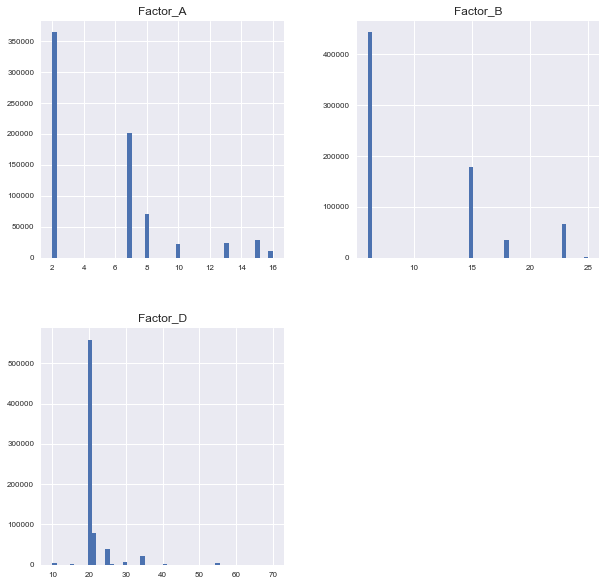

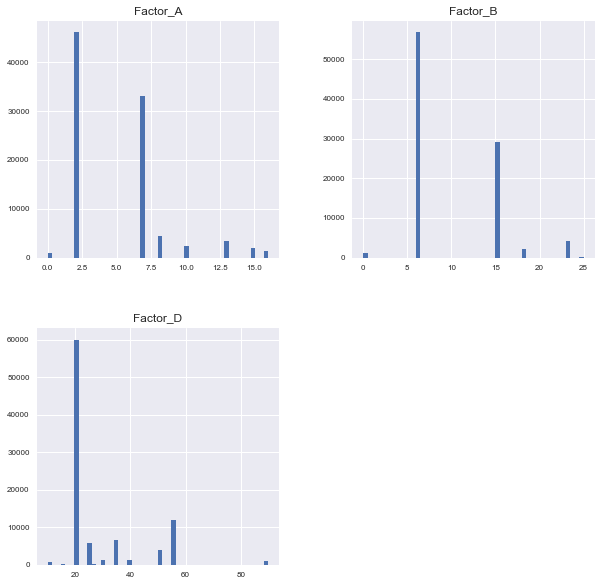

In [165]:
df_approved_num = df.loc[df.Transaction_Status == 0, ["Factor_A", "Factor_B", "Factor_D"]]
df_declined_num = df.loc[df.Transaction_Status == 1, ["Factor_A", "Factor_B", "Factor_D"]]
#histogram
df_approved_num.hist(figsize=(10,10), bins=50, xlabelsize=8, ylabelsize=8)
df_declined_num.hist(figsize=(10,10), bins=50, xlabelsize=8, ylabelsize=8)
# sns.hist(df[df.Transaction_Status == 0].Factor_A)
# sns.distplot(df["Transaction_Status" == 1].Factor_A)

In [137]:
set(df['Factor_A'])

{0, 2, 7, 8, 10, 13, 15, 16}

In [58]:
df['Transaction_Status'].describe()

count       813940
unique           2
top       Approved
freq        720544
Name: Transaction_Status, dtype: object

In [57]:
df.groupby(['Transaction_Status']).Response.value_counts()

Transaction_Status  Response
Approved            1020        710054
                    1885         10490
Declined            1320         42427
                    1240         15776
                    1330          8254
                    1250          4842
                    1060          3474
                    1420          3472
                    1290          3081
                    1841          2135
                    1857          1962
                    1100          1900
                    1843          1172
                    1570          1026
                    1310           722
                    1861           667
                    1450           475
                    1801           461
                    1807           349
                    1865           206
                    1812           199
                    1815           160
                    1070           148
                    1803           126
                    1026           

In [59]:
df['Factor_C'].value_counts()

VI    438189
MC    235002
AX    105072
DI     35677
Name: Factor_C, dtype: int64

In [50]:
df['Transaction_Timestamp_New'] = [datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S.%f") for i in df['Transaction_Timestamp']]

In [56]:

df['Response'].describe()

count     813940
unique        44
top         1020
freq      710054
Name: Response, dtype: int64

In [52]:
df['Transaction_Timestamp'].describe()

count                      813940
unique                     813889
top       2009-12-06 16:11:15.836
freq                            2
Name: Transaction_Timestamp, dtype: object

In [42]:
import datetime
import calendar
        
date_text = "2009-12-06 16:11:15.22"
date = datetime.datetime.strptime(date_text, "%Y-%m-%d %H:%M:%S.%f")

In [43]:
date

datetime.datetime(2009, 12, 6, 16, 11, 15, 220000)

In [32]:
df['Response'].describe()

count    813940.000000
mean       1067.543625
std         148.839260
min        1020.000000
25%        1020.000000
50%        1020.000000
75%        1020.000000
max        1913.000000
Name: Response, dtype: float64

In [21]:
df.columns.values

array(['Account_ID', 'Transaction_Timestamp', 'Factor_A', 'Factor_B',
       'Factor_C', 'Factor_D', 'Factor_E', 'Response', 'Transaction_Status'], dtype=object)

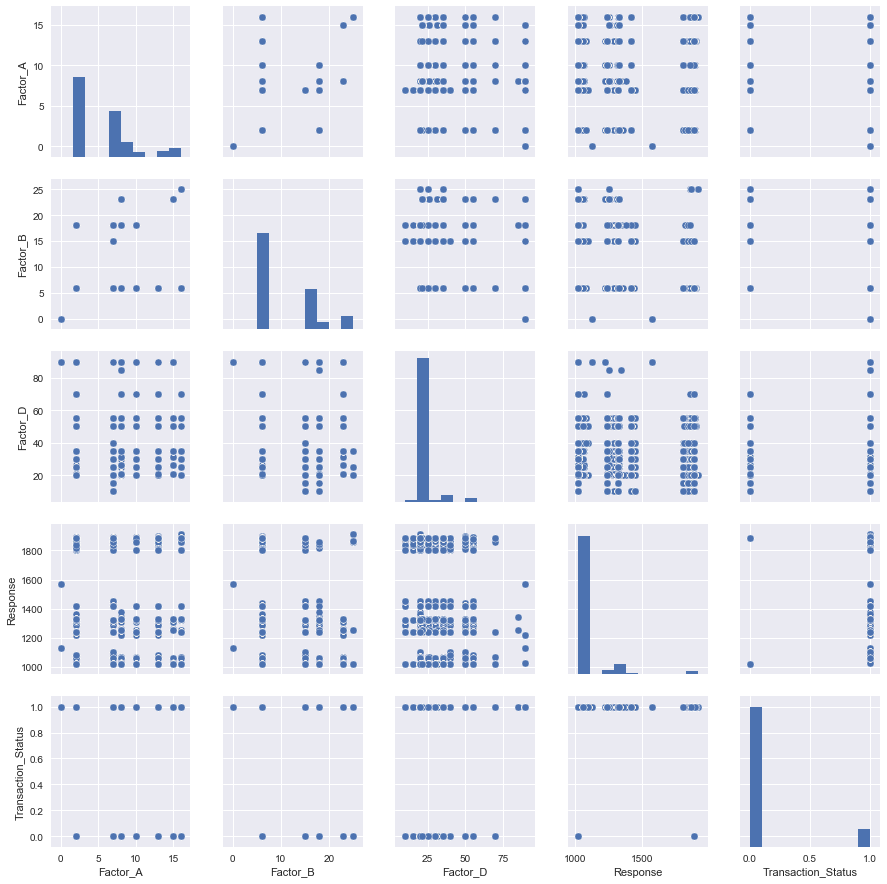

In [135]:
#scatterplot
sns.set()
cols = ['Factor_A', 'Factor_B', 'Factor_C', 'Factor_D', 'Factor_E', 'Response', 'Transaction_Status']
sns.pairplot(df[cols], size = 2.5)
plt.show()